 When we include %matplotlib inline at the beginning of a notebook, it tells Jupyter to display all Matplotlib plots inline and they will appear directly in the notebook instead of in a separate window.

In [ ]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

Quanvolutional Neural Networks {#quanvolution}
==============================


General setup
-------------

This Python code requires *PennyLane* with the *TensorFlow* interface
and the plotting library *matplotlib*.


We start by intsalling the PennyLane library into our notebook

In [2]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 3.2 MB/s eta 0:00:00


These lines of code helps us to import all the needed libraries for running our codes

In [3]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

Setting of the main hyper-parameters of the model
=================================================


In [9]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "/content/quanvolution"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

Loading of the MNIST dataset
============================

Here, we get the MNIST dataset from Keras. To make this demo run faster, we only use a small number of training and test images. Of course, we can get better results if we use the entire dataset.


In [5]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Quantum circuit as a convolution kernel
=======================================


This code sets up a quantum circuit that takes 4 classical input values, encodes them into qubits, applies a random quantum circuit, and then measures the output states of the qubits.

In [6]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

 This function quanv takes an input image, processes it in 2x2 blocks using a quantum circuit, and returns a feature map that is smaller in size (14x14) but contains information from the original image.

In [7]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

Quantum pre-processing of the dataset
=====================================




This code verifies whether preprocessing is activated, processes the training and test images with a quantum processing function, saves the resulting images, and subsequently loads them back into the program for additional use.

In [10]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


The code cell illustrate the impact of the quantum convolution layer on a set of samples.


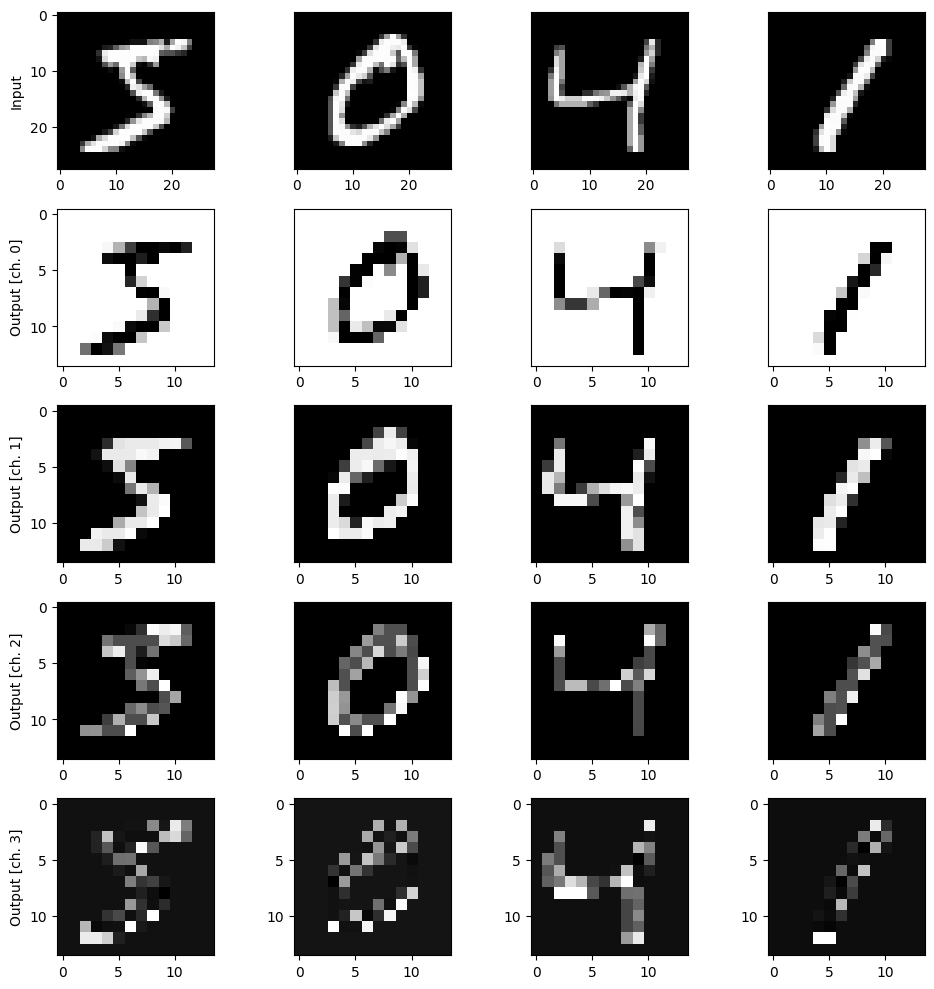

In [11]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

Hybrid quantum-classical model
==============================
Here we define a Keras model to classify the $10$ different digits of the MNIST dataset with default parameters



In [12]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

Training
========

We create an instance of the model, followed by training and validating it using the dataset that has already undergone quantum convolution preprocessing.


In [13]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 78ms/step - accuracy: 0.1600 - loss: 2.6388 - val_accuracy: 0.2000 - val_loss: 2.3375
Epoch 2/30
13/13 - 0s - 25ms/step - accuracy: 0.4600 - loss: 1.8698 - val_accuracy: 0.1667 - val_loss: 2.1353
Epoch 3/30
13/13 - 0s - 5ms/step - accuracy: 0.6000 - loss: 1.5884 - val_accuracy: 0.3000 - val_loss: 1.9482
Epoch 4/30
13/13 - 0s - 6ms/step - accuracy: 0.6600 - loss: 1.2969 - val_accuracy: 0.4667 - val_loss: 1.8186
Epoch 5/30
13/13 - 0s - 10ms/step - accuracy: 0.7800 - loss: 1.0745 - val_accuracy: 0.4667 - val_loss: 1.7130
Epoch 6/30
13/13 - 0s - 11ms/step - accuracy: 0.9000 - loss: 0.9046 - val_accuracy: 0.5000 - val_loss: 1.6273
Epoch 7/30
13/13 - 0s - 10ms/step - accuracy: 0.9400 - loss: 0.7643 - val_accuracy: 0.5000 - val_loss: 1.5566
Epoch 8/30
13/13 - 0s - 6ms/step - accuracy: 0.9400 - loss: 0.6514 - val_accuracy: 0.5000 - val_loss: 1.4972
Epoch 9/30
13/13 - 0s - 10ms/step - accuracy: 0.9400 - loss: 0.5596 - val_accuracy: 0.5000 - val_loss: 1.4473
Epoch 10/30
1

To compare the results obtained with and without the quantum convolution layer, we also create a classical instance of the model, which will be trained and validated directly using the raw MNIST images.




In [14]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 64ms/step - accuracy: 0.1200 - loss: 2.3995 - val_accuracy: 0.2333 - val_loss: 2.1522
Epoch 2/30
13/13 - 0s - 12ms/step - accuracy: 0.3200 - loss: 2.0040 - val_accuracy: 0.3667 - val_loss: 2.0153
Epoch 3/30
13/13 - 0s - 10ms/step - accuracy: 0.5600 - loss: 1.7207 - val_accuracy: 0.4333 - val_loss: 1.8852
Epoch 4/30
13/13 - 0s - 11ms/step - accuracy: 0.7000 - loss: 1.4818 - val_accuracy: 0.5000 - val_loss: 1.7646
Epoch 5/30
13/13 - 0s - 10ms/step - accuracy: 0.8400 - loss: 1.2793 - val_accuracy: 0.6333 - val_loss: 1.6597
Epoch 6/30
13/13 - 0s - 6ms/step - accuracy: 0.8600 - loss: 1.1092 - val_accuracy: 0.7000 - val_loss: 1.5722
Epoch 7/30
13/13 - 0s - 6ms/step - accuracy: 0.9000 - loss: 0.9670 - val_accuracy: 0.7000 - val_loss: 1.5002
Epoch 8/30
13/13 - 0s - 6ms/step - accuracy: 0.9200 - loss: 0.8481 - val_accuracy: 0.7000 - val_loss: 1.4407
Epoch 9/30
13/13 - 0s - 6ms/step - accuracy: 0.9400 - loss: 0.7484 - val_accuracy: 0.7333 - val_loss: 1.3910
Epoch 10/30
13

Results
=======

We can now visualize the test accuracy and test loss in relation to the number of training epochs.


<ipython-input-15-c3ef9ba498fb>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


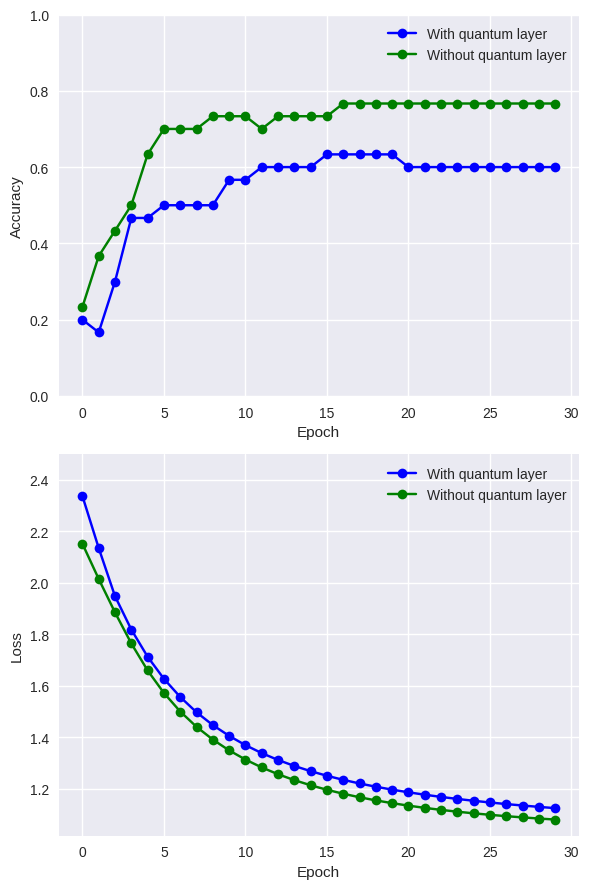

In [15]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

References
==========

1.  Maxwell Henderson, Samriddhi Shakya, Shashindra Pradhan, Tristan
    Cook. \"Quanvolutional Neural Networks: Powering Image Recognition
    with Quantum Circuits.\"
    [arXiv:1904.04767](https://arxiv.org/abs/1904.04767), 2019.

About the author
================
